In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import average_precision_for_user, f1_score
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [2]:
ALGORITHMS = ['cbf', 'mf', 'user-user', 'switch_cbf_10', 'switch_cbf_11', 'switch_mf_10', 'switch_mf_11', 'switch_perbias_10', 'switch_perbias_10', 'switch_item-item_10', 'switch_item-item_11',]

SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category', 'F1']

set_ratings(read_ratings_from_file())
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  f1_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(average_precision_for_user(top_n, user_id))
    f1_values.append(f1_score(top_n, user_id))
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['F1'][algorithm] = calculate_statistics(f1_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['F1'] = pd.concat([results['F1'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

In [3]:
width = 10 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

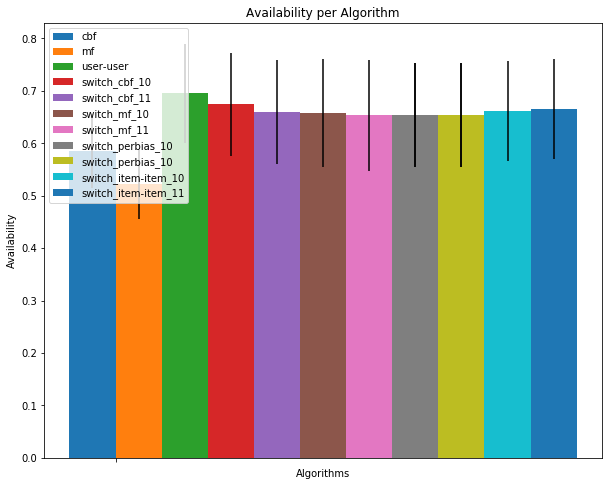

In [4]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [5]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.510899,0.532006,0.566868,0.623718,0.796855,0.802512,0.585363,0.480483,0.070753
mf,0.468187,0.468187,0.498603,0.564393,0.684572,0.684572,0.521616,0.468187,0.065243
user-user,0.567862,0.624114,0.688028,0.761760,0.908394,0.918805,0.695152,0.500692,0.094819
switch_cbf_10,0.552941,0.599488,0.672648,0.744888,0.883832,0.908289,0.674533,0.500692,0.098281
switch_cbf_11,0.523881,0.568400,0.654242,0.736993,0.861321,0.908289,0.660078,0.508016,0.098776
switch_mf_10,0.510899,0.585103,0.657337,0.736730,0.861321,0.908289,0.657054,0.468187,0.102834
switch_mf_11,0.498603,0.568212,0.653627,0.733178,0.861321,0.908289,0.652917,0.468187,0.105916
switch_perbias_10,0.552890,0.566868,0.644927,0.733178,0.861321,0.908289,0.653729,0.468187,0.099873
switch_perbias_10,0.552890,0.566868,0.644927,0.733178,0.861321,0.908289,0.653729,0.468187,0.099873
switch_item-item_10,0.557988,0.566868,0.653627,0.736730,0.861321,0.908289,0.661516,0.462140,0.094856


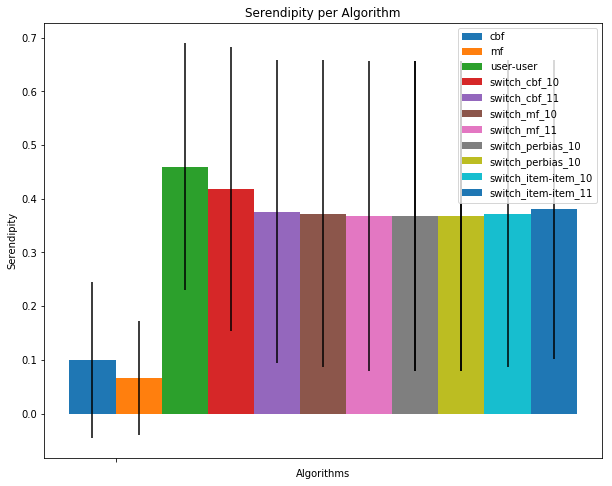

In [6]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [7]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.0,0.0,0.0,0.2,0.602,0.8,0.100,0.0,0.145602
mf,0.0,0.0,0.0,0.2,0.400,0.4,0.066,0.0,0.106038
user-user,0.2,0.2,0.4,0.6,0.802,1.0,0.460,0.0,0.230651
switch_cbf_10,0.0,0.2,0.4,0.6,0.802,1.0,0.418,0.0,0.263962
switch_cbf_11,0.0,0.2,0.4,0.6,0.802,1.0,0.376,0.0,0.281823
switch_mf_10,0.0,0.2,0.4,0.6,0.802,1.0,0.372,0.0,0.285685
switch_mf_11,0.0,0.0,0.4,0.6,0.802,1.0,0.368,0.0,0.289441
switch_perbias_10,0.0,0.0,0.4,0.6,0.802,1.0,0.368,0.0,0.289441
switch_perbias_10,0.0,0.0,0.4,0.6,0.802,1.0,0.368,0.0,0.289441
switch_item-item_10,0.0,0.2,0.4,0.6,0.802,1.0,0.372,0.0,0.285685


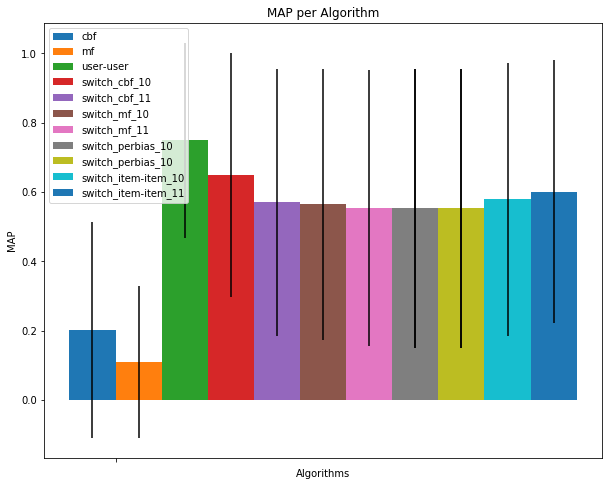

In [8]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [9]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.202042,0.0,0.310513
mf,0.0000,0.000000,0.000000,0.200000,1.0,1.0,0.109167,0.0,0.218548
user-user,0.3325,0.588889,0.850000,1.000000,1.0,1.0,0.749278,0.0,0.281404
switch_cbf_10,0.0000,0.366667,0.750000,1.000000,1.0,1.0,0.648889,0.0,0.351189
switch_cbf_11,0.0000,0.237500,0.659028,0.950000,1.0,1.0,0.570667,0.0,0.384887
switch_mf_10,0.0000,0.200000,0.659028,0.950000,1.0,1.0,0.565000,0.0,0.390684
switch_mf_11,0.0000,0.150000,0.659028,0.950000,1.0,1.0,0.554667,0.0,0.398677
switch_perbias_10,0.0000,0.000000,0.659028,0.950000,1.0,1.0,0.553000,0.0,0.401332
switch_perbias_10,0.0000,0.000000,0.659028,0.950000,1.0,1.0,0.553000,0.0,0.401332
switch_item-item_10,0.0000,0.237500,0.679167,1.000000,1.0,1.0,0.578833,0.0,0.392934


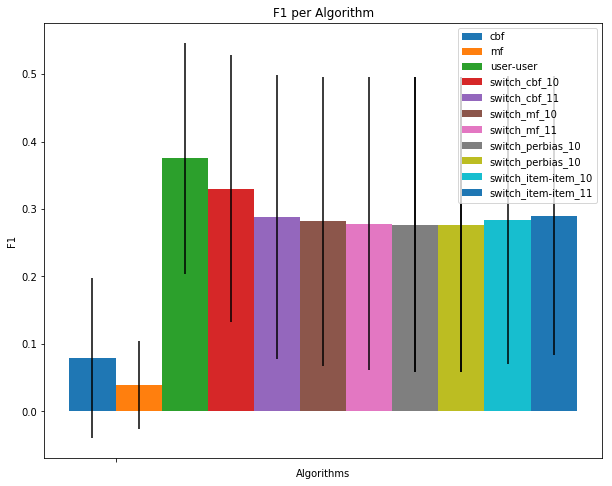

In [10]:
metric = results['F1']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('F1')
ax.set_title('F1 per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()


metric

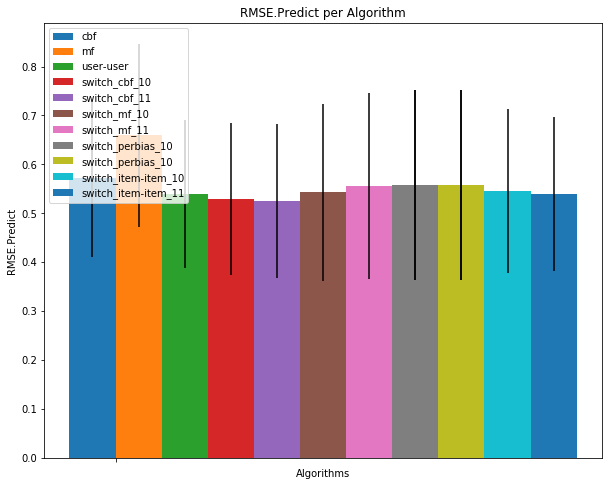

In [11]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [12]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.371323,0.458708,0.565546,0.665676,0.989574,1.017527,0.572387,0.266683,0.161299
mf,0.428535,0.524264,0.638710,0.746580,1.133340,1.258139,0.659029,0.311749,0.187732
user-user,0.379496,0.451870,0.521396,0.608613,0.961865,1.027937,0.539678,0.000000,0.150756
switch_cbf_10,0.360302,0.433645,0.504012,0.604373,0.961761,1.017527,0.528654,0.000000,0.154828
switch_cbf_11,0.358380,0.427540,0.504012,0.603204,0.989574,1.017527,0.525687,0.000000,0.157543
switch_mf_10,0.358975,0.432748,0.506085,0.605103,1.069060,1.258139,0.542431,0.000000,0.181487
switch_mf_11,0.360302,0.445374,0.508765,0.612164,1.133340,1.258139,0.555273,0.000000,0.190093
switch_perbias_10,0.360447,0.448642,0.508931,0.612164,1.134652,1.389332,0.557421,0.000000,0.194361
switch_perbias_10,0.360447,0.448642,0.508931,0.612164,1.134652,1.389332,0.557421,0.000000,0.194361
switch_item-item_10,0.362627,0.448642,0.518415,0.608613,0.992843,1.131650,0.546332,0.000000,0.167584


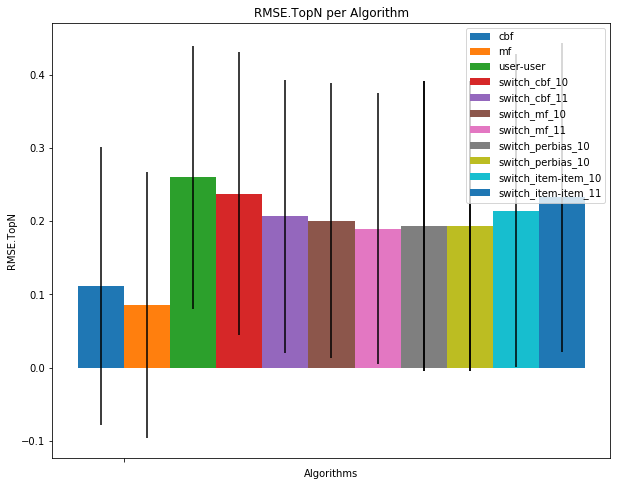

In [13]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [14]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.163600,0.641167,0.811303,0.111610,0.0,0.189255
mf,0.000000,0.000000,0.000000,0.057908,0.670296,0.885882,0.085722,0.0,0.181740
user-user,0.055927,0.117116,0.230005,0.399643,0.680138,0.931245,0.259641,0.0,0.179276
switch_cbf_10,0.000000,0.069966,0.193063,0.400282,0.680138,0.931245,0.237247,0.0,0.193006
switch_cbf_11,0.000000,0.031650,0.160085,0.363980,0.639830,0.677601,0.206644,0.0,0.186113
switch_mf_10,0.000000,0.016547,0.158995,0.346520,0.639830,0.677601,0.200864,0.0,0.187301
switch_mf_11,0.000000,0.005842,0.141508,0.341384,0.596695,0.677601,0.189739,0.0,0.184777
switch_perbias_10,0.000000,0.005842,0.141508,0.341384,0.680763,0.993779,0.193823,0.0,0.198096
switch_perbias_10,0.000000,0.005842,0.141508,0.341384,0.680763,0.993779,0.193823,0.0,0.198096
switch_item-item_10,0.000000,0.022806,0.161465,0.363980,0.885850,1.143694,0.214479,0.0,0.213785


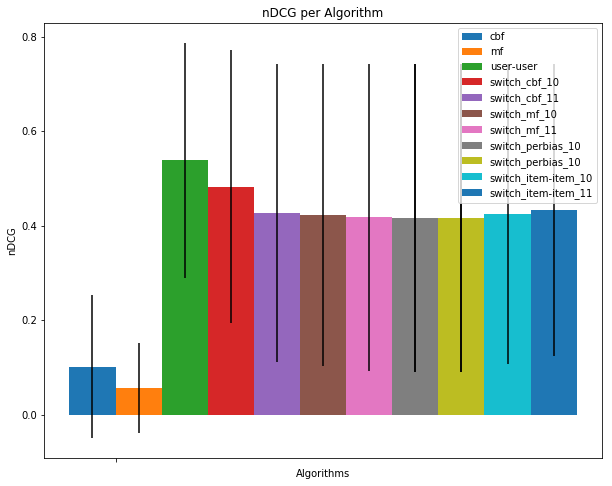

In [15]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [16]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.205765,0.518268,0.757924,0.101620,0.0,0.150979
mf,0.000000,0.000000,0.000000,0.121038,0.363126,0.364263,0.057055,0.0,0.095502
user-user,0.242076,0.363114,0.515847,0.732568,1.000000,1.000000,0.538416,0.0,0.248525
switch_cbf_10,0.000000,0.265847,0.484153,0.726229,1.000000,1.000000,0.482681,0.0,0.289710
switch_cbf_11,0.000000,0.144809,0.394809,0.726229,1.000000,1.000000,0.426704,0.0,0.315515
switch_mf_10,0.000000,0.121038,0.394809,0.726229,1.000000,1.000000,0.422756,0.0,0.319047
switch_mf_11,0.000000,0.090779,0.394809,0.726229,1.000000,1.000000,0.417338,0.0,0.323890
switch_perbias_10,0.000000,0.072623,0.394809,0.726229,1.000000,1.000000,0.415885,0.0,0.324996
switch_perbias_10,0.000000,0.072623,0.394809,0.726229,1.000000,1.000000,0.415885,0.0,0.324996
switch_item-item_10,0.000000,0.144809,0.394809,0.726229,1.000000,1.000000,0.424859,0.0,0.317490


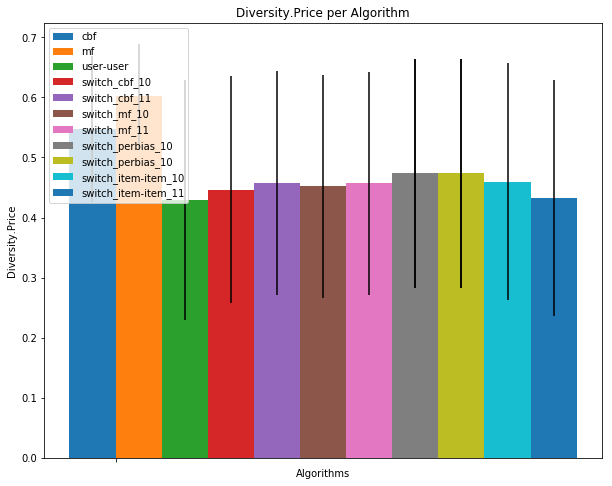

In [17]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [18]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.32,0.48,0.60,0.64,0.72,0.72,0.5472,0.24,0.121178
mf,0.40,0.64,0.64,0.64,0.64,0.64,0.6016,0.40,0.087985
user-user,0.16,0.32,0.48,0.56,0.72,0.72,0.4288,0.00,0.200006
switch_cbf_10,0.16,0.32,0.48,0.58,0.72,0.72,0.4464,0.00,0.189037
switch_cbf_11,0.16,0.32,0.48,0.64,0.72,0.72,0.4576,0.00,0.186275
switch_mf_10,0.16,0.32,0.48,0.64,0.72,0.72,0.4520,0.00,0.185343
switch_mf_11,0.16,0.38,0.48,0.64,0.72,0.72,0.4568,0.00,0.185660
switch_perbias_10,0.16,0.38,0.56,0.64,0.72,0.72,0.4736,0.00,0.190555
switch_perbias_10,0.16,0.38,0.56,0.64,0.72,0.72,0.4736,0.00,0.190555
switch_item-item_10,0.16,0.32,0.48,0.64,0.72,0.72,0.4600,0.00,0.197707


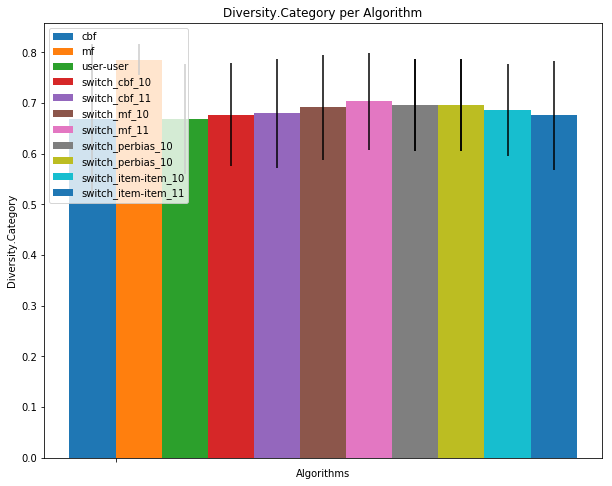

In [19]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [20]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.56,0.64,0.72,0.72,0.8,0.8,0.6680,0.00,0.149399
mf,0.72,0.80,0.80,0.80,0.8,0.8,0.7856,0.72,0.030735
user-user,0.56,0.56,0.72,0.72,0.8,0.8,0.6688,0.32,0.108234
switch_cbf_10,0.56,0.64,0.72,0.72,0.8,0.8,0.6768,0.32,0.101458
switch_cbf_11,0.56,0.64,0.72,0.72,0.8,0.8,0.6800,0.32,0.107629
switch_mf_10,0.56,0.64,0.72,0.80,0.8,0.8,0.6920,0.32,0.103923
switch_mf_11,0.56,0.64,0.72,0.80,0.8,0.8,0.7032,0.32,0.095529
switch_perbias_10,0.56,0.64,0.72,0.72,0.8,0.8,0.6960,0.32,0.090863
switch_perbias_10,0.56,0.64,0.72,0.72,0.8,0.8,0.6960,0.32,0.090863
switch_item-item_10,0.56,0.64,0.72,0.72,0.8,0.8,0.6856,0.32,0.090690


In [21]:
pd.DataFrame.from_dict(results['Coverage.Item'])

,cbf,mf,switch_cbf_10,switch_cbf_11,switch_item-item_10,switch_item-item_11,switch_mf_10,switch_mf_11,switch_perbias_10,user-user
0,0.205,0.045,0.72,0.625,0.67,0.68,0.62,0.615,0.615,0.755


In [22]:
pd.DataFrame.from_dict(results['Coverage.User'])

,cbf,mf,switch_cbf_10,switch_cbf_11,switch_item-item_10,switch_item-item_11,switch_mf_10,switch_mf_11,switch_perbias_10,user-user
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
